In [16]:
import numpy as np
name = input('Name of the Model: ')
epochs = int(input('Number of Epochs: '))
batch_size = int(input('Batch Size: '))

TypeError: 'int' object is not callable

In [111]:
#!pip install tensorflow
#!pip install pedalboard
#import soundfile as sf
import tensorflow as tf
#from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
#from tensorflow.keras.activations import tanh, elu, relu
#from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import os
import glob
import matplotlib.pyplot as plt
#import math
import h5py
import librosa
from pedalboard import (
    Pedalboard,
    Convolution,
    Compressor,
    Chorus,
    Distortion,
    Gain,
    Reverb,
    Limiter,
    LadderFilter,
    Phaser,
)

In [67]:
# EDIT THIS SECTION FOR USER INPUTS
#

path = 'models/'+name+'_functional/'

audiosource = 'Trial_Data/GuitSigClean_Monophon'
#name = 'Chorus_Test'
if not os.path.exists(path):
    os.makedirs(path)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

epochs = 10
fs = 44100
batch_size = 10 
test_size = 0.2
input_size = 100

train_mode = 1     # 0 = speed training, 
                   # 1 = accuracy training 
                   # 2 = extended training
if train_mode == 0:         # Speed Training
    learning_rate = 0.01 
    conv1d_strides = 12    
    conv1d_filters = 16
    hidden_units = 36
elif train_mode == 1:       # Accuracy Training (~10x longer than Speed Training)
    learning_rate = 0.01 
    conv1d_strides = 4
    conv1d_filters = 36
    hidden_units= 64
else:                       # Extended Training (~60x longer than Accuracy Training)
    learning_rate = 0.0005 
    conv1d_strides = 3
    conv1d_filters = 36
    hidden_units= 96
    

A model with the same name already exists. Please choose a new name.


In [4]:
class WindowArray(Sequence):
        
    def __init__(self, x, y, window_len, batch_size=32):
        self.x = x
        self.y = y[window_len-1:] 
        self.window_len = window_len
        self.batch_size = batch_size
        
    def __len__(self):
        l = len(self.x)
        return (len(self.x) - self.window_len +1) // self.batch_size
    
    def __getitem__(self, index):
        x_out = np.stack([self.x[idx: idx+self.window_len] for idx in range(index*self.batch_size, (index+1)*self.batch_size)])
        y_out = self.y[index*self.batch_size:(index+1)*self.batch_size]
        return x_out, y_out

def pre_emphasis_filter(x, coeff=0.95):
    return tf.concat([x, x - coeff * x], 1)
    
def error_to_signal(y_true, y_pred): 
    """
    Error to signal ratio with pre-emphasis filter:
    """
    y_true, y_pred = pre_emphasis_filter(y_true), pre_emphasis_filter(y_pred)
    return K.sum(tf.pow(y_true - y_pred, 2), axis=0) / (K.sum(tf.pow(y_true, 2), axis=0) + 1e-10)
    
def save_wav(name, data):
    wavfile.write(name, fs, data.flatten().astype(np.float32))

# normalize data to loudest signal
def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm

# add fadeout with length samples   
def apply_fadeout(audio, length):
    # convert to audio indices (samples)
    #length = int(duration*sr)
    end = len(audio)
    start = end - length
    # compute fade out curve
    # linear fade
    fade_curve = np.linspace(1.0, 0.0, length)
    audio[start:end] = audio[start:end] *fade_curve
    return audio

In [26]:
# loads guitar signals, cuts them to 1 sec and rewrties them with fade out and normalized
# has been done already

for i, file in enumerate (glob.glob(audiosource+'*.wav')):
    x, samplerate = librosa.load('Trial_Data/GuitSigClean_Monophon/Monophon (%d).wav' %i, mono=True, sr=fs, duration=1.0, dtype=np.float32)          
    x = apply_fadeout(normalize(x),100)
    save_wav('Trial_Data/GuitSigClean_1/Monophon_1sec_(%d).wav' %(input), x)
    #with sf.SoundFile('Trial_Data/GuitSigClean_1/Monophon_1sec_(%d).wav' %(input), 'w', samplerate=fs, channels=len(x.shape)) as f:
    #    f.write(x)

x_test, ssmp = librosa.load('Trial_Data/GuitSigClean_1/Monophon_1sec_(1).wav', sr=44100, dtype=np.float32)
print(type(x_test))


<class 'numpy.ndarray'>


In [98]:
# writing pedalboard processed audio sorted by effect type
# reading processed audio and append to dry and wet array
fx_list = [Chorus(), Phaser(), Distortion()]
fx_names = ['Chorus', 'Phaser', 'Distortion']
fx_list = [Compressor()]
fx_names = ['Compressor']
dry = []
wet = []
effect_indices = []
for fx_iter,fx in enumerate(fx_list): # 0 = Chorus, 1 = Phaser, 2 = Distortion
    board = Pedalboard([fx], sample_rate=fs)
    for input in range(1, 401, 1):
        x, samplerate = librosa.load('Trial_Data//GuitSigClean_1/Monophon_1sec_(%d).wav' %input, mono=True, sr=fs, duration=1.0, dtype=np.float32)
        x = apply_fadeout(normalize(x),100)
        output = board(x)
        output = apply_fadeout(output, 100)
        dry.append(x)
        wet.append(output)
        effect_indices.append(fx)
        #save_wav('Trial_Data/GuitSig_with_%s/Monophon_with_%s (%d).wav' %(fx_names[fx],fx_names[fx],input), output)

dry = np.array(dry)
wet = np.array(wet)
effect_indices = np.array(effect_indices)
#dataset_dry = tf.data.Dataset.from_tensor_slices(dry)
#dataset_wet = tf.data.Dataset.from_tensor_slices(wet)
#dataset_effect_indices = tf.data.Dataset.from_tensor_slices(effect_indices)
wet.shape

# define testset
xtrain, xtest, ytrain, ytest=train_test_split(dry, wet, test_size=0.15)

In [151]:
# Create Functional Model ###########################################
# Name: CRAFx (see Martinez et al. Deep Learning for Black Box Modelling)

# Parameters:
epochs = 10
fs = 44100
batch_size = 10 
#test_size = 0.2
#input_size = 100


learning_rate = 0.01 
conv1d_strides = 1  
conv1d_filters = 32

# maxpool layer
max_pool_1_strides = 64
hidden_units = 36

# LSTM Layers
lstm_1_units = 64
lstm_2_units = 32
lstm_3_units = 16

### Input section
input_shape= (4096,1)
inputs = tf.keras.Input(shape=input_shape,batch_size=9)
conv1D_1 = Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same', input_shape=(input_shape), name='First_1D_Conv')(inputs)
# hier muss irgendwie das mittlere (aktuelle, als residual gesafed werden)
# was bedeutet abs??
conv1D_1_loc = Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same', input_shape=(input_shape), name='2nd_1D_Conv_local')(conv1D_1)
max_pool_1 = MaxPooling1D(pool_size=2, strides=max_pool_1_strides, padding='same', data_format='channels_last', name='Max_Pool_1')(conv1D_1_loc)

### LSTM
lstm_1 = LSTM(lstm_1_units,dropout=0.1,recurrent_dropout=0.1, activation="tanh",go_backwards=True, name='LSTM')(max_pool_1)
#lstm_2 = LSTM(lstm_2_units,dropout=0.1,recurrent_dropout=0.1, activation="tanh",go_backwards=True, name='LSTM')(lstm_1)
#lstm_3 = LSTM(lstm_3_units,dropout=0.1,recurrent_dropout=0.1,go_backwards=True, name='LSTM')(lstm_2)
#bi_lstm_1 = tf.keras.layers.Bidirectional( LSTM(lstm_2_units,dropout=0.1,recurrent_dropout=0.1, activation="tanh", name='LSTM_2'), input_shape=(input_shape))



outputs = lstm_1
model_functional_api = tf.keras.Model(inputs=inputs, outputs=outputs, name="functional_model")
model_functional_api.summary()
model_functional_api.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[error_to_signal])

Model: "functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(9, 4096, 1)]            0         
                                                                 
 First_1D_Conv (Conv1D)      (9, 4096, 32)             416       
                                                                 
 2nd_1D_Conv_local (Conv1D)  (9, 4096, 32)             12320     
                                                                 
 Max_Pool_1 (MaxPooling1D)   (9, 64, 32)               0         
                                                                 
 LSTM (LSTM)                 (9, 128)                  82432     
                                                                 
Total params: 95,168
Trainable params: 95,168
Non-trainable params: 0
_________________________________________________________________


In [125]:
inputs

<KerasTensor: shape=(None, 9, 1, 4096) dtype=float32 (created by layer 'input_34')>

In [72]:
# Train Functional Model ###################################################
history = model_functional_api.fit(xtrain, ytrain, epochs=epochs, verbose=1, validation_split=0.2, shuffle=True)    
model_functional_api.save(path+name+'_'+'functional_model'+'.h5', overwrite=True)

# Run Prediction #################################################
print("Running prediction..")

val_loss, val_acc = model_functional_api.evaluate(xtrain, ytrain, verbose=2)
print("Loss:", val_loss, " Accuracy:", val_acc)

prediction = model_functional_api.predict(xtest)

save_wav( path+'y_pred.wav', prediction)
save_wav( path+'x_test.wav', xtest)
save_wav( path+'y_test.wav', ytest)

# Add additional data to the saved model (like input_size)
filename = path+name+'_'+'functional_model'+'.h5'
f = h5py.File(filename, 'a')
grp = f.create_group("info")
dset = grp.create_dataset("input_size", (1,), dtype='int16')
dset[0] = input_size
f.close()

Epoch 1/10
9/9 [==============================] - 28s 3s/step - loss: 0.0552 - error_to_signal: 111.1401 - val_loss: 0.0504 - val_error_to_signal: 35.8683
Epoch 2/10
9/9 [==============================] - 25s 3s/step - loss: 0.0478 - error_to_signal: 51.8209 - val_loss: 0.0502 - val_error_to_signal: 49.4450
Epoch 3/10
9/9 [==============================] - 26s 3s/step - loss: 0.0472 - error_to_signal: 35.8374 - val_loss: 0.0496 - val_error_to_signal: 28.5294
Epoch 4/10
9/9 [==============================] - 25s 3s/step - loss: 0.0469 - error_to_signal: 28.3753 - val_loss: 0.0495 - val_error_to_signal: 34.9218
Epoch 5/10
9/9 [==============================] - 26s 3s/step - loss: 0.0465 - error_to_signal: 26.5803 - val_loss: 0.0495 - val_error_to_signal: 21.9550
Epoch 6/10
9/9 [==============================] - 24s 3s/step - loss: 0.0463 - error_to_signal: 17.5189 - val_loss: 0.0495 - val_error_to_signal: 18.2291
Epoch 7/10
9/9 [==============================] - 26s 3s/step - loss: 0.046

PermissionError: [Errno 13] Permission denied: 'models/initial_test_functional/y_pred.wav'

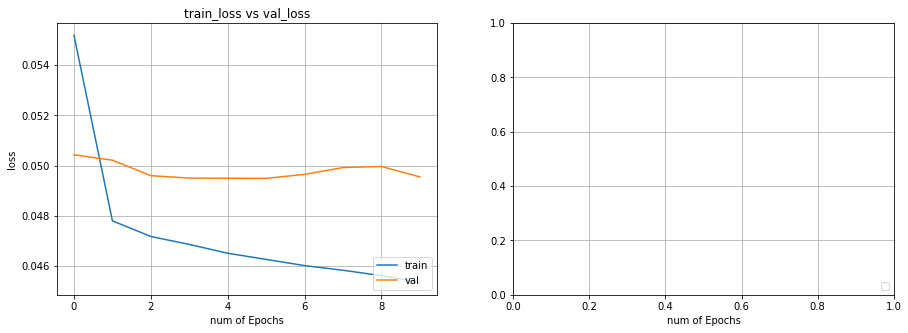

In [74]:
# visualizing losses and accuracy
train_loss, val_loss = history.history['loss'], history.history['val_loss']
#train_acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

# setup plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
 
# plot loss
ax[0].plot(range(epochs), train_loss)
ax[0].plot(range(epochs), val_loss)
ax[0].set_ylabel('loss')
ax[0].set_title('train_loss vs val_loss')

# plot accuracy
#ax[1].plot(range(epochs), train_acc)
#ax[1].plot(range(epochs), val_acc)
#ax[1].set_ylabel('accuracy')
#ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'],loc=4)
    a.set_xlabel('num of Epochs')
    
plt.show()